<a href="https://colab.research.google.com/github/williamlidberg/Analyses-of-Environmental-Data-2/blob/main/Geopandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Geopandas tutorial
A guide for dummies by William Liberg

[Geopandas](https://geopandas.org/en/stable/) enables you to easily do operations in python that would otherwise require a spatial database such as PostGIS. This tutorial will teach you some basic operations and hopefully inspire you to explore geopandas further. 

## Download some data




The first thing we need to do is to grab some data. A fun dataset to play around with is drainage ditches detected by [DitchNet](https://ascelibrary.org/doi/full/10.1061/JIDEDH.IRENG-9796). 

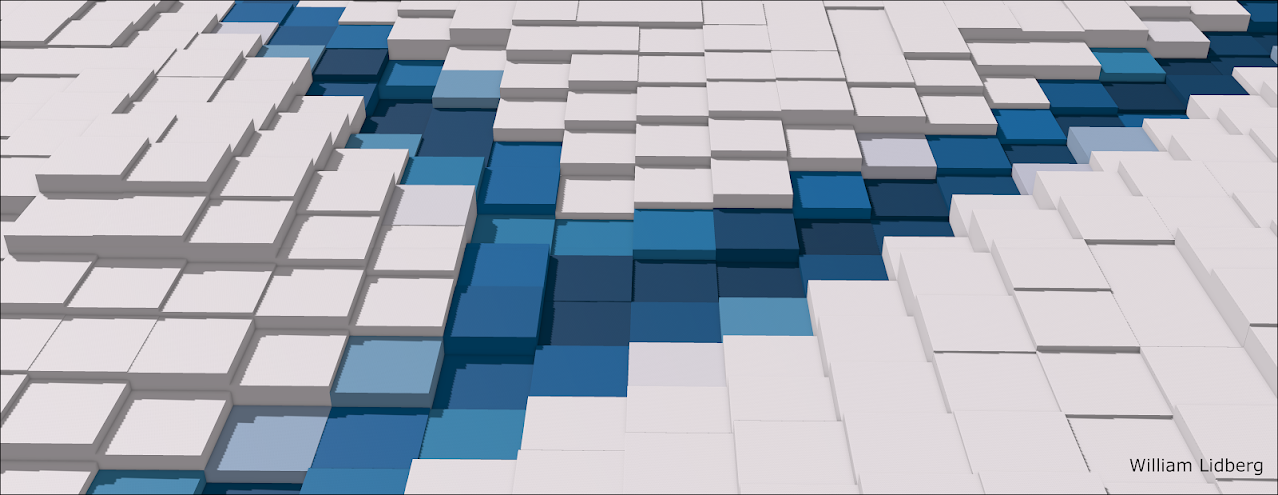
This dataset is avalible for all of Sweden but since google colab is somewhat limited we will settle for Gotland. Download and unzip the dataset with these two lines of code.

In [ ]:
!wget https://gpt.vic-metria.nu/data/land/Diken/Diken_Sverige/Diken_lansvis/Diken_I.zip
!unzip /content/Diken_I.zip

The unpacked data can be found at this location in google colab: /content/Diken_I.gpkg


Notice that the data is stored as a .gpkg file. What is this nonsens you might ask, where is my shapefile!? The truth is that shapefiles are limited in how much data they can handle and modern geospatial data is quickly expanding beyond that limit. Geopackage (.gpkg) is another way to package and store vector data. **Shapefiles must die!** Now install geopandas so we can start to play around with the data. python packages can be installed from [pypip](https://pypi.org/project/geopandas/) with the pip command in the terminal.

## Set up geopandas

In [ ]:
!pip install geopandas

The first line imports the geopandas pythonpackage and names it "gpd". This is normaly done to avoid having to type out the full name when using in later. The second line reads all data from the geopackage into a geopandas dataframe. This is a large dataset and will take about a minute. 

In [ ]:
import geopandas as gpd
ditches = gpd.read_file('/content/Diken_I.gpkg')

A geodataframe is a normal dataframe with a added column called geometry. This colum defines the shapes and locations of each feature. Typing the name of the dataframe gives us an overview of the information. The column Typ describes the ditch type in the following categories:
*    Dike på åkermark = ditch on aggricultural land
*    Skogsdike = forest ditch
*    Vägdike = roadside ditch
*    Dike på öppen våtmark = ditch on open wetland
*    Övrigt dike = other ditches
  

In [ ]:
ditches

This dataset contains 301342 line segments. Lets summarize the column "Shape_Lenght" by the column "Type" and explore what has been drained on Gotland.

In [ ]:
gropuped = ditches.groupby("Typ").sum("Shape_Length")
gropuped

Woah, those are some large numbers. Lets convert them from m to km to make more sense of this.

In [ ]:
gropuped["lenght_km"] = gropuped['Shape_Length']/1000
gropuped

Meh, numbers are still hard. Lets plot it instead.

In [ ]:
gropuped.plot.bar(y="lenght_km")

Much better, most ditches on Gotland are forest ditches. But why are there so few ditches on wetlands? Do they even have open wetlands on Gotland?! Lets download and unzip some wetland data and check!

In [ ]:
!wget https://gpt.vic-metria.nu/data/land/VMI/ursprunglig_digitalisering/I_Gotland_VMI.zip
!unzip /content/I_Gotland_VMI.zip

This time the data is stored as a shapefile: /content/I_Gotland_VMI_Ytor.shp. We also seem to have downloaded some documentation: /content/VMI beskrivning 20190909.pdf. Lets ignore it and inspect the data instead. The shapefile can be read into a geodataframe with the same command as we used before.

In [ ]:
import geopandas as gpd
wetlands = gpd.read_file('/content/I_Gotland_VMI_Ytor.shp')
wetlands

In [ ]:
wetlands["AREAL_HA"].sum()

We seem to have at least 1084 wetlands on Gotland that covers 24350.1 ha. Honestly, who uses ha anyway? See if you can recalculate to a more civilized unit such as km<sup>2</sup>.

# Plotting geospatial data

The fun part about geospatial data is that we can see it. Now we will try a few different methods of plotting and interracting with the dataset. The most basic method is to just use geopandas and add .plot at the end of the geodatadataframe.

### Raw geopandas

In [ ]:
wetlands.plot(column="NVKLASS")

Plotting ditches takes a few seconds due to the large number of vector lines.

In [ ]:
ditches.plot()

### With matplotlib

There are a number of python packages made for plotting data. one of the most popular package is matplotlib.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (14,10)
wetlands.plot(column='NVKLASS',cmap='Greens_r', legend=True) # NVKLASS is a classification based on valuable nature types.

We can also plot multiple layers on top of each other and zoom in on a smaller area by setting x and y limits.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.rcParams["figure.figsize"] = (8,8)
base = wetlands.plot(column='NVKLASS',cmap='Greens_r', legend=True)
ditches.plot(ax=base, legend=True)
plt.xlim(718512, 730677)
plt.ylim(6401936, 6394119)

## Do drained wetlands have lower nature value classification?

To awsner this question we need to summarise the ditch length within each wetland. Start by intersecting the two dataframes and calcualting the length of the intersected stream segments. We can then summarize the lenght by nature classes.

In [ ]:
intersect = gpd.overlay(ditches, wetlands, how='intersection')
intersect["length"] = intersect.length
wetland_ditch_length = intersect.groupby("NVKLASS").sum("length")
wetland_ditch_length["ditch_density"] = wetland_ditch_length["length"]/wetland_ditch_length["AREAL_HA"]

Seaborn is another nice package for easy plotting. Use it to plot ditch density by the "wetland nature value class".

In [ ]:
import seaborn as sns
sns.barplot(data=wetland_ditch_length,x=wetland_ditch_length.index, y="ditch_density")

There we have it. "valuable" wetlands have a lower density of drainage ditches. Now lets use this insight to build a machine learning model that we can use to classify wetlands. 

# Machine learning
Since there is a correlation between ditch density and wetland classification we can build a model that predicts wetland class by the ditch length and wetland area. Lets create a new dataframe with only the relevant information.

In [ ]:
join_left_df = wetlands.sjoin(intersect, how="left") # join 
modeldata = join_left_df[['NVKLASS_left', 'length', 'AREAL_HA_left']].copy()# copy the relevant columns to a new dataframe
modeldata = modeldata.fillna(0) # fill empty columns with 0

We will use [sklearn](https://scikit-learn.org/stable/) to build and test a basic [random forest](https://en.wikipedia.org/wiki/Random_forest) model. To evaluate weather the model is good or not we will split the data into training 80% and testing 20%.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

train, test = train_test_split(modeldata, test_size=0.2) # split the data into training data and testing data

rf = RandomForestClassifier(n_estimators = 500) # define the model
rf.fit(train.drop("NVKLASS_left", axis=1), train["NVKLASS_left"]) # train the model

Now we have a trained model, the next step is to evaluate how good the model preforms on new data.

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay

y_pred = rf.predict(test.drop("NVKLASS_left", axis=1)) # use the model to predict new data
accuracy = accuracy_score(test["NVKLASS_left"], y_pred) # compare prediction to the classification
print("Accuracy:", accuracy*100,"%")

The accuracy shows how many % the model makes a correct classification of the "nature value". This model can be used to predict valuable wetlands based on their area and the total lenght of ditches.

# Implement the model
This section is only here to demonstrate how to implement the model to predict valauble wetlands in other areas. Here I choose Blekinke because it is so tiny. First we download and unpack the wetland dataset and ditch dataset.

In [ ]:
!wget https://gpt.vic-metria.nu/data/land/Diken/Diken_Sverige/Diken_lansvis/Diken_K.zip
!wget https://gpt.vic-metria.nu/data/land/VMI/ursprunglig_digitalisering/K_Blekinge_VMI.zip
!unzip -o /content/K_Blekinge_VMI.zip
!unzip -o /content/Diken_K.zip

### Read the data into geodataframes
google colab is great but a tad slow. Be patient.

In [ ]:
wetlands = gpd.read_file('/content/K_Blekinge_VMI_Ytor.shp')
ditches = gpd.read_file('/content/Diken_K.gpkg')

### Preprocess the data 

In [ ]:
intersect = gpd.overlay(ditches, wetlands, how='intersection')
intersect["length"] = intersect.length
join_left_df = wetlands.sjoin(intersect, how="left") # join 
modeldata = join_left_df[['NVKLASS_left', 'length', 'AREAL_HA_left']].copy()# copy the relevant columns to a new dataframe
modeldata = modeldata.fillna(0)

### Apply the model to Blekinge

In [ ]:
import pandas as pd
import matplotlib as plt

y_pred = rf.predict(modeldata.drop("NVKLASS_left", axis=1)) # use the model to predict new data
column_names=["pred"]
df2 = pd.DataFrame(y_pred, columns=column_names)

ax = sns.countplot(x=df2["pred"])
ax.set(xlabel='Predicted nature value class', ylabel='Number of wetlands')



## References

https://ascelibrary.org/doi/full/10.1061/JIDEDH.IRENG-9796

Contact: William.lidberg@slu.se

Twitter: https://twitter.com/William_Lidberg